In [1]:
import sys
sys.path.append("../")
import pandas as pd
from housing import data_info, eda, feature_engineering, outliers, commons, data_holder, models, final_pipeline
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Data

**Data preview**

In [2]:
data=pd.read_csv('../data/house_sales.csv')
data_holder.set_data(data)
data_info.preview()

Data shape:  (18448, 16)


price  num_bed  num_bath  size_house  size_lot  num_floors  is_waterfront  \
0  221900        3      1.00        1180      5650         1.0              0   
1  538000        3      2.25        2570      7242         2.0              0   
2  180000        2      1.00         770     10000         1.0              0   
3  604000        4      3.00        1960      5000         1.0              0   
4  510000        3      2.00        1680      8080         1.0              0   

   condition  size_basement  year_built  renovation_date    zip   latitude  \
0          3              0        1955                0  98178  47.511234   
1          3            400        1951             1991  98125  47.721023   
2          3              0        1933                0  98028  47.737927   
3          5            910        1965                0  98136  47.520820   
4          3              0        1987                0  98074  47.616812   

    longitude  avg_size_neighbor_houses  avg_size_neighbor_lot  
0 -122.256775                      1340                   5650  
1 -122.318862                      1690                   7639  
2 -122.233196                      2720                   8062  
3 -122.393185                      1360                   5000  
4 -122.044901                      1800                   7503

*Feature descriptions:*

> * **price** - The last price the house was sold for (Target)
> * **num_bed** - The number of bedrooms
> * **num_bath** - The number of bathrooms (fractions mean the house has a toilet-only or shower/bathtub-only bathroom)
> * **size_house** (includes basement) - The size of the house
> * **size_lot** - The size of the lot
> * **num_floors** - The number of floors
> * **is_waterfront** - Whether or not the house is a waterfront house (0 means it is not a waterfront house whereas 1 means that it is a waterfront house)
> * **condition** - How worn out the house is. Ranges from 1 (needs repairs all over the place) to 5 (the house is very well maintained)
> * **size_basement** - The size of the basement
> * **year_built** - The year the house was built
> * **renovation_date** - The year the house was renovated for the last time. 0 means the house has never been renovated
> * **zip** - The zip code
> * **latitude** - Latitude
> * **longitude** - Longitude
> * **avg_size_neighbor_houses** - The average house size of the neighbors
> * **avg_size_neighbor_lot** - The average lot size of the neighbors

**Let's look at the missing values we'll need to impute**

In [3]:
data_info.missing_values()

Data missing values: 
price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64


Great! no missing values

**Duplicates**

In [4]:
data_info.duplicates()

Duplicates in Data set: 3, (0.02%)


Too few duplicates to affect our results considerably

**Cardinality of deatures**

In [5]:
data_info.cardinality()

Data types: 

price                         int64
num_bed                       int64
num_bath                    float64
size_house                    int64
size_lot                      int64
num_floors                  float64
is_waterfront                 int64
condition                     int64
size_basement                 int64
year_built                    int64
renovation_date               int64
zip                           int64
latitude                    float64
longitude                   float64
avg_size_neighbor_houses      int64
avg_size_neighbor_lot         int64
dtype: object


Data unique values: 

price                        3670
num_bed                        12
num_bath                       30
size_house                    956
size_lot                     8807
num_floors                      6
is_waterfront                   2
condition                       5
size_basement                 283
year_built                    116
renovation_date                6

# EDA

Exploring the data to gather insights

**Target distribution**

Price describe: 
count    1.844800e+04
mean     5.423624e+05
std      3.720135e+05
min      7.800000e+04
25%      3.218375e+05
50%      4.500000e+05
75%      6.480000e+05
max      7.700000e+06
Name: price, dtype: float64


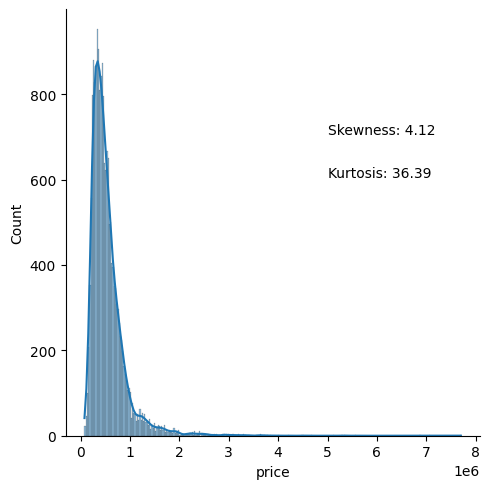

In [6]:
eda.target_distribution()

As skewness is > 1 the target is highly skewed  
As the target has high kurtosis the variance may be because of the presence of extreme outliers  
We may consider this later when we decide if we should transform the target

**Relationship with features**

Let's look at the correlation matrix for the features, and 'zoom in' in the  
10 features with the greatest correlation coeficient (with respect to our target 'price')

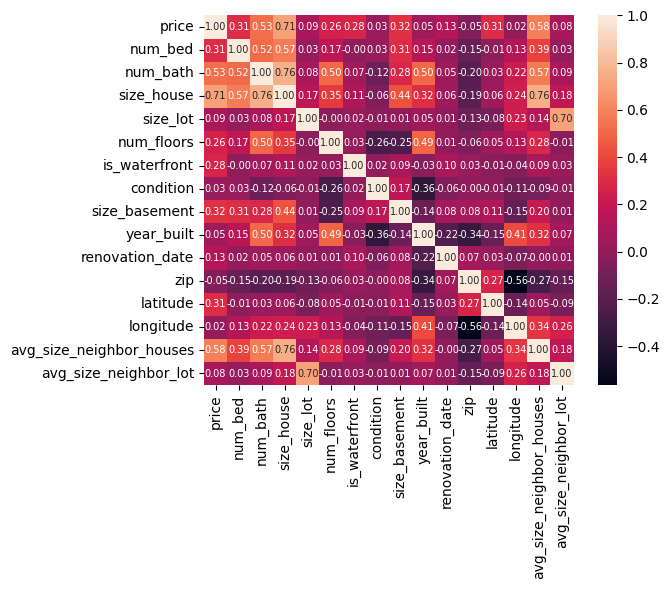

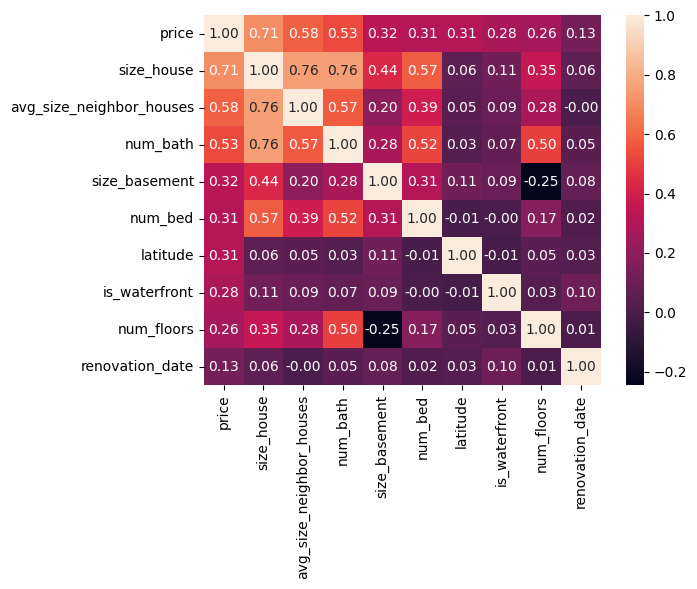

In [7]:
eda.corrmat()

Do the highest correlations make sense in the context of our domain knowledge?
- The highest correlations (>0.7) are:  
    - **Price - size-house**  
        - *Bigger houses tend to cost more*
    - **num_bath - size_house**
        - *Bigger houses tend to mean more people who need more baths* 
    - **avg_size_neighbor_houses - size_house**
        - *Houses tend to be similarly priced and sized in the same location*
    - **avg_size_neighbor_lot - size_lot**
        - *Same as before, houses and therefore lots tend to be similarly priced and sized in the same location*
- (>0.57)  
    - **num_bed - size_house**
        - *Same as before, bigger houses more people more bedrooms*
    - **num_bath - avg_size_neighbor_houses** 
        - *num_bath -> size_house -> avg_size_neighbor_houses*

**Collinearity**  
Two suspects of feature collinearity from the corr matrix are **avg_size_neighbor_houses - size_house** and **num_bath - size_house** because of their high correlation coeficients.  
We will keep this in mind and later decide if we drop one of each pair.  
*analyze collinearity between zip and lat,long. As both determine location*

**Scatter plot for pair of features**

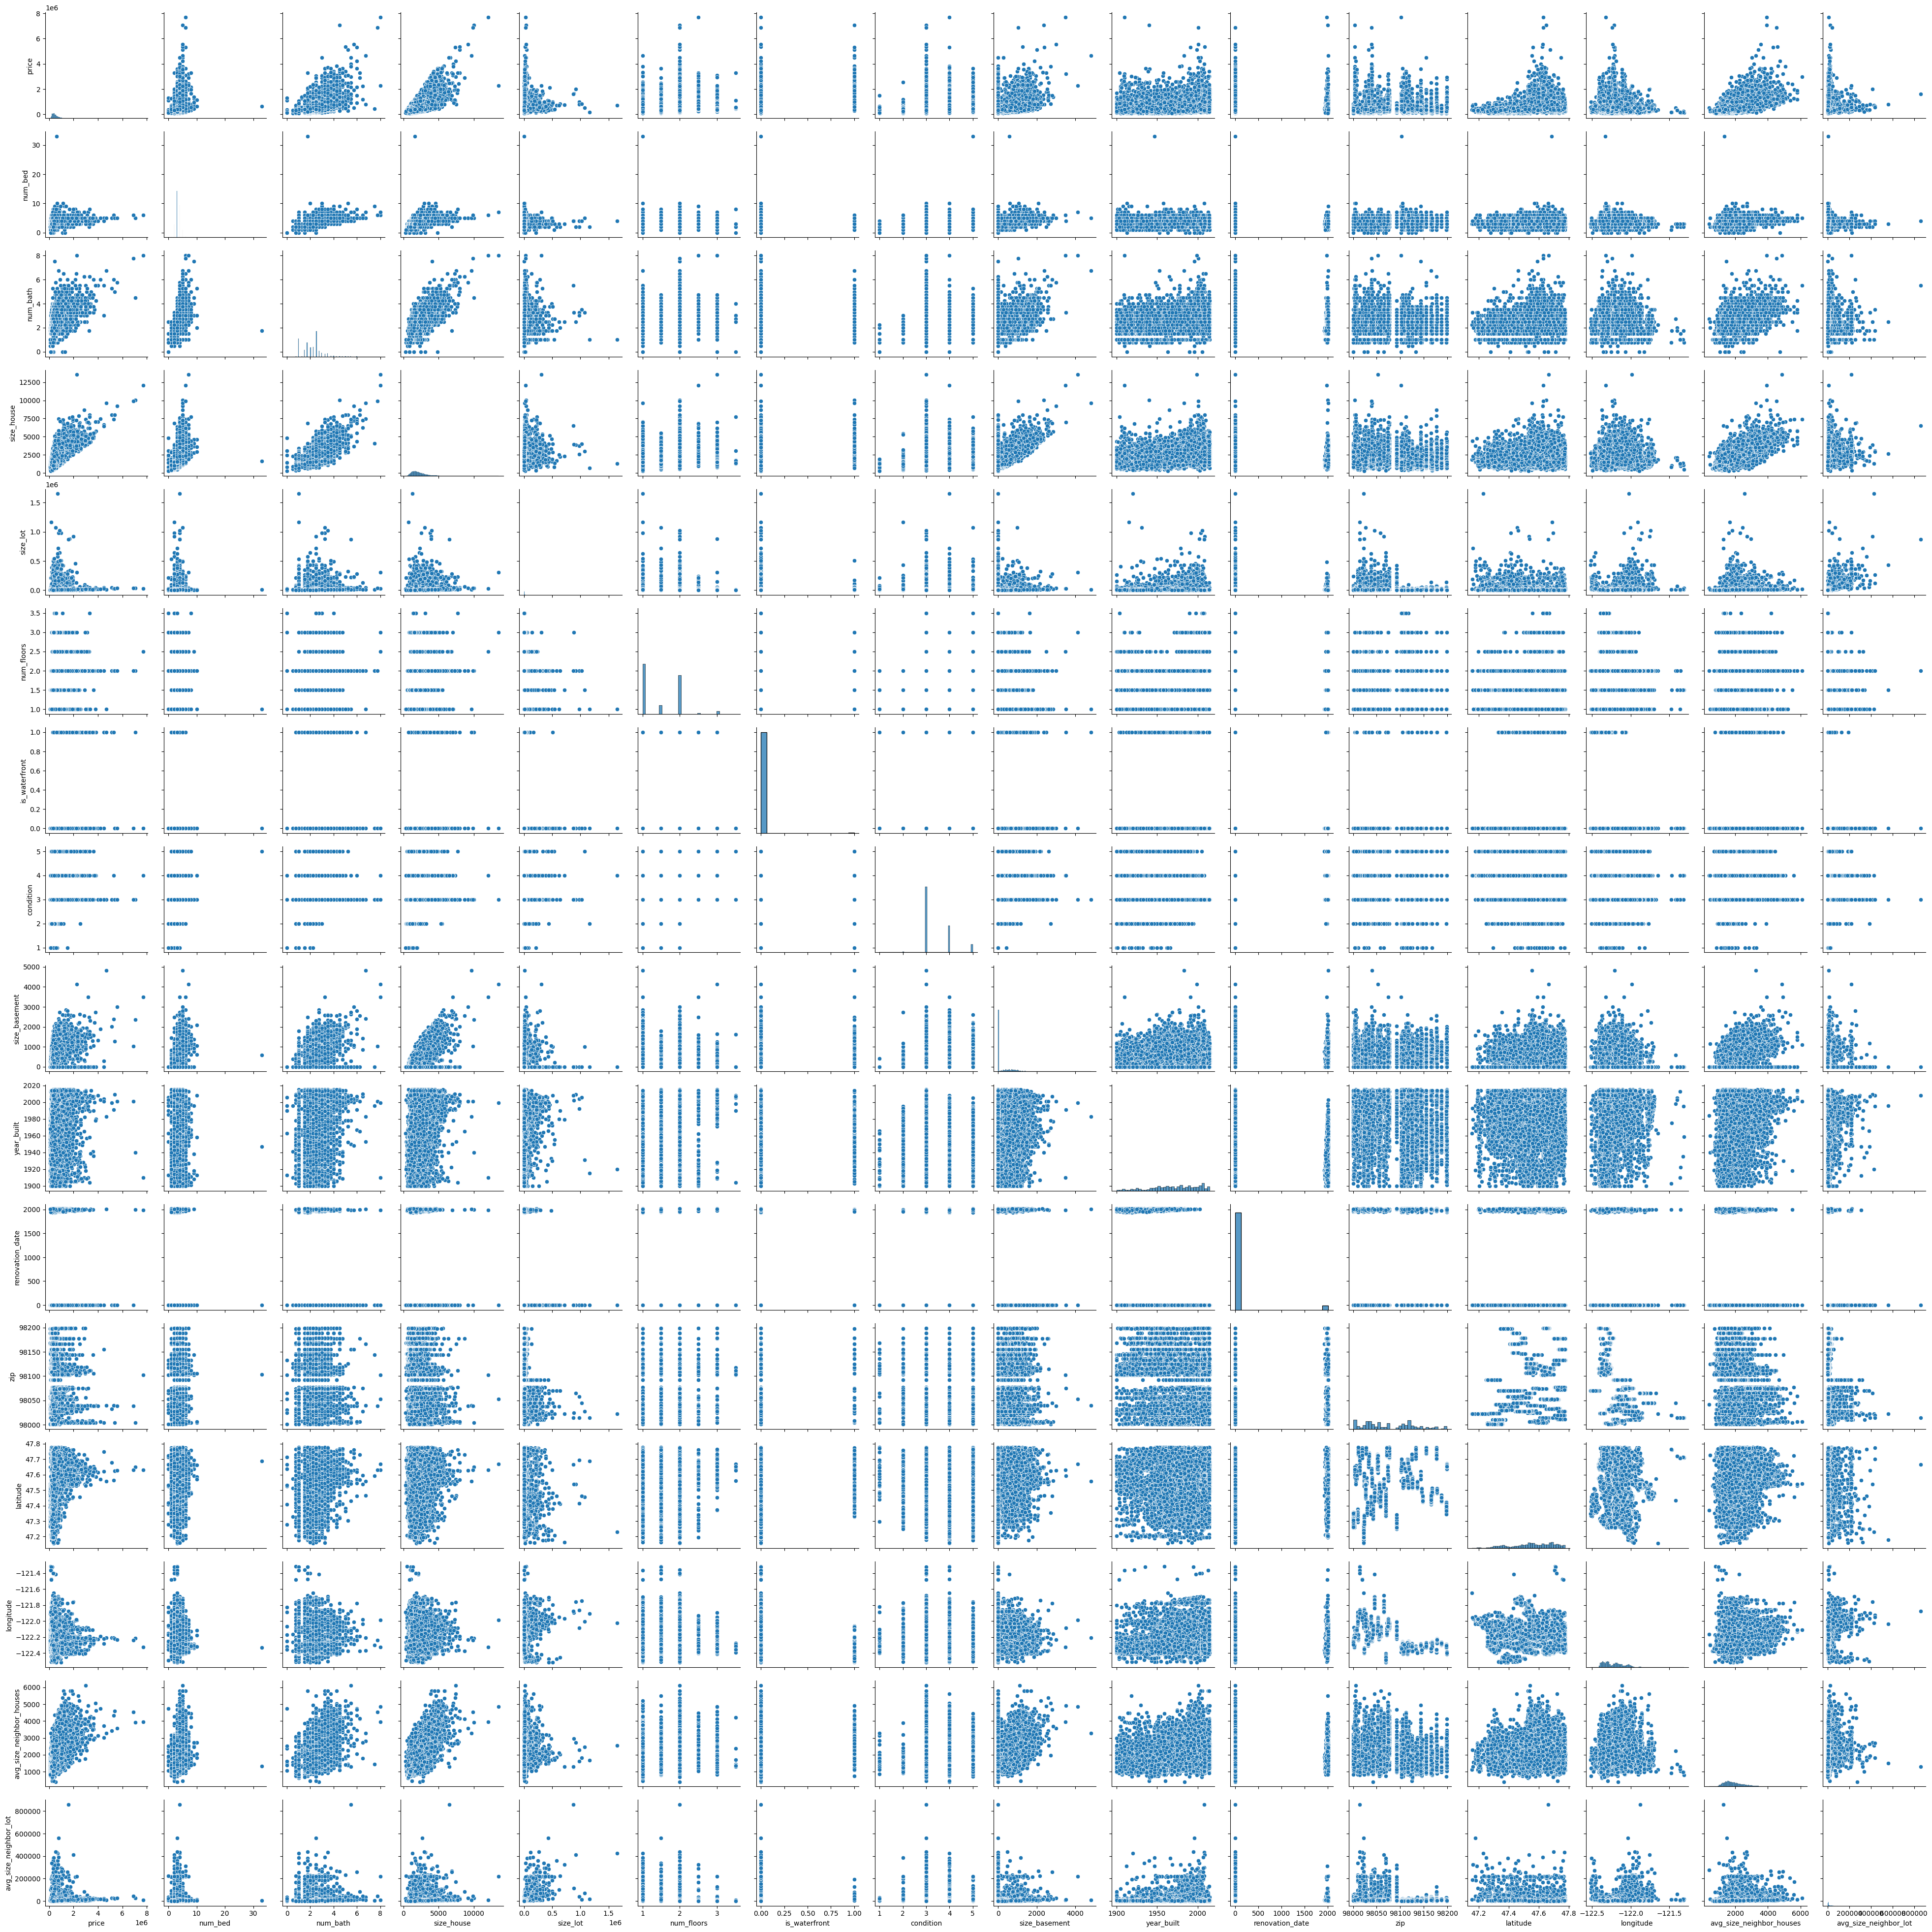

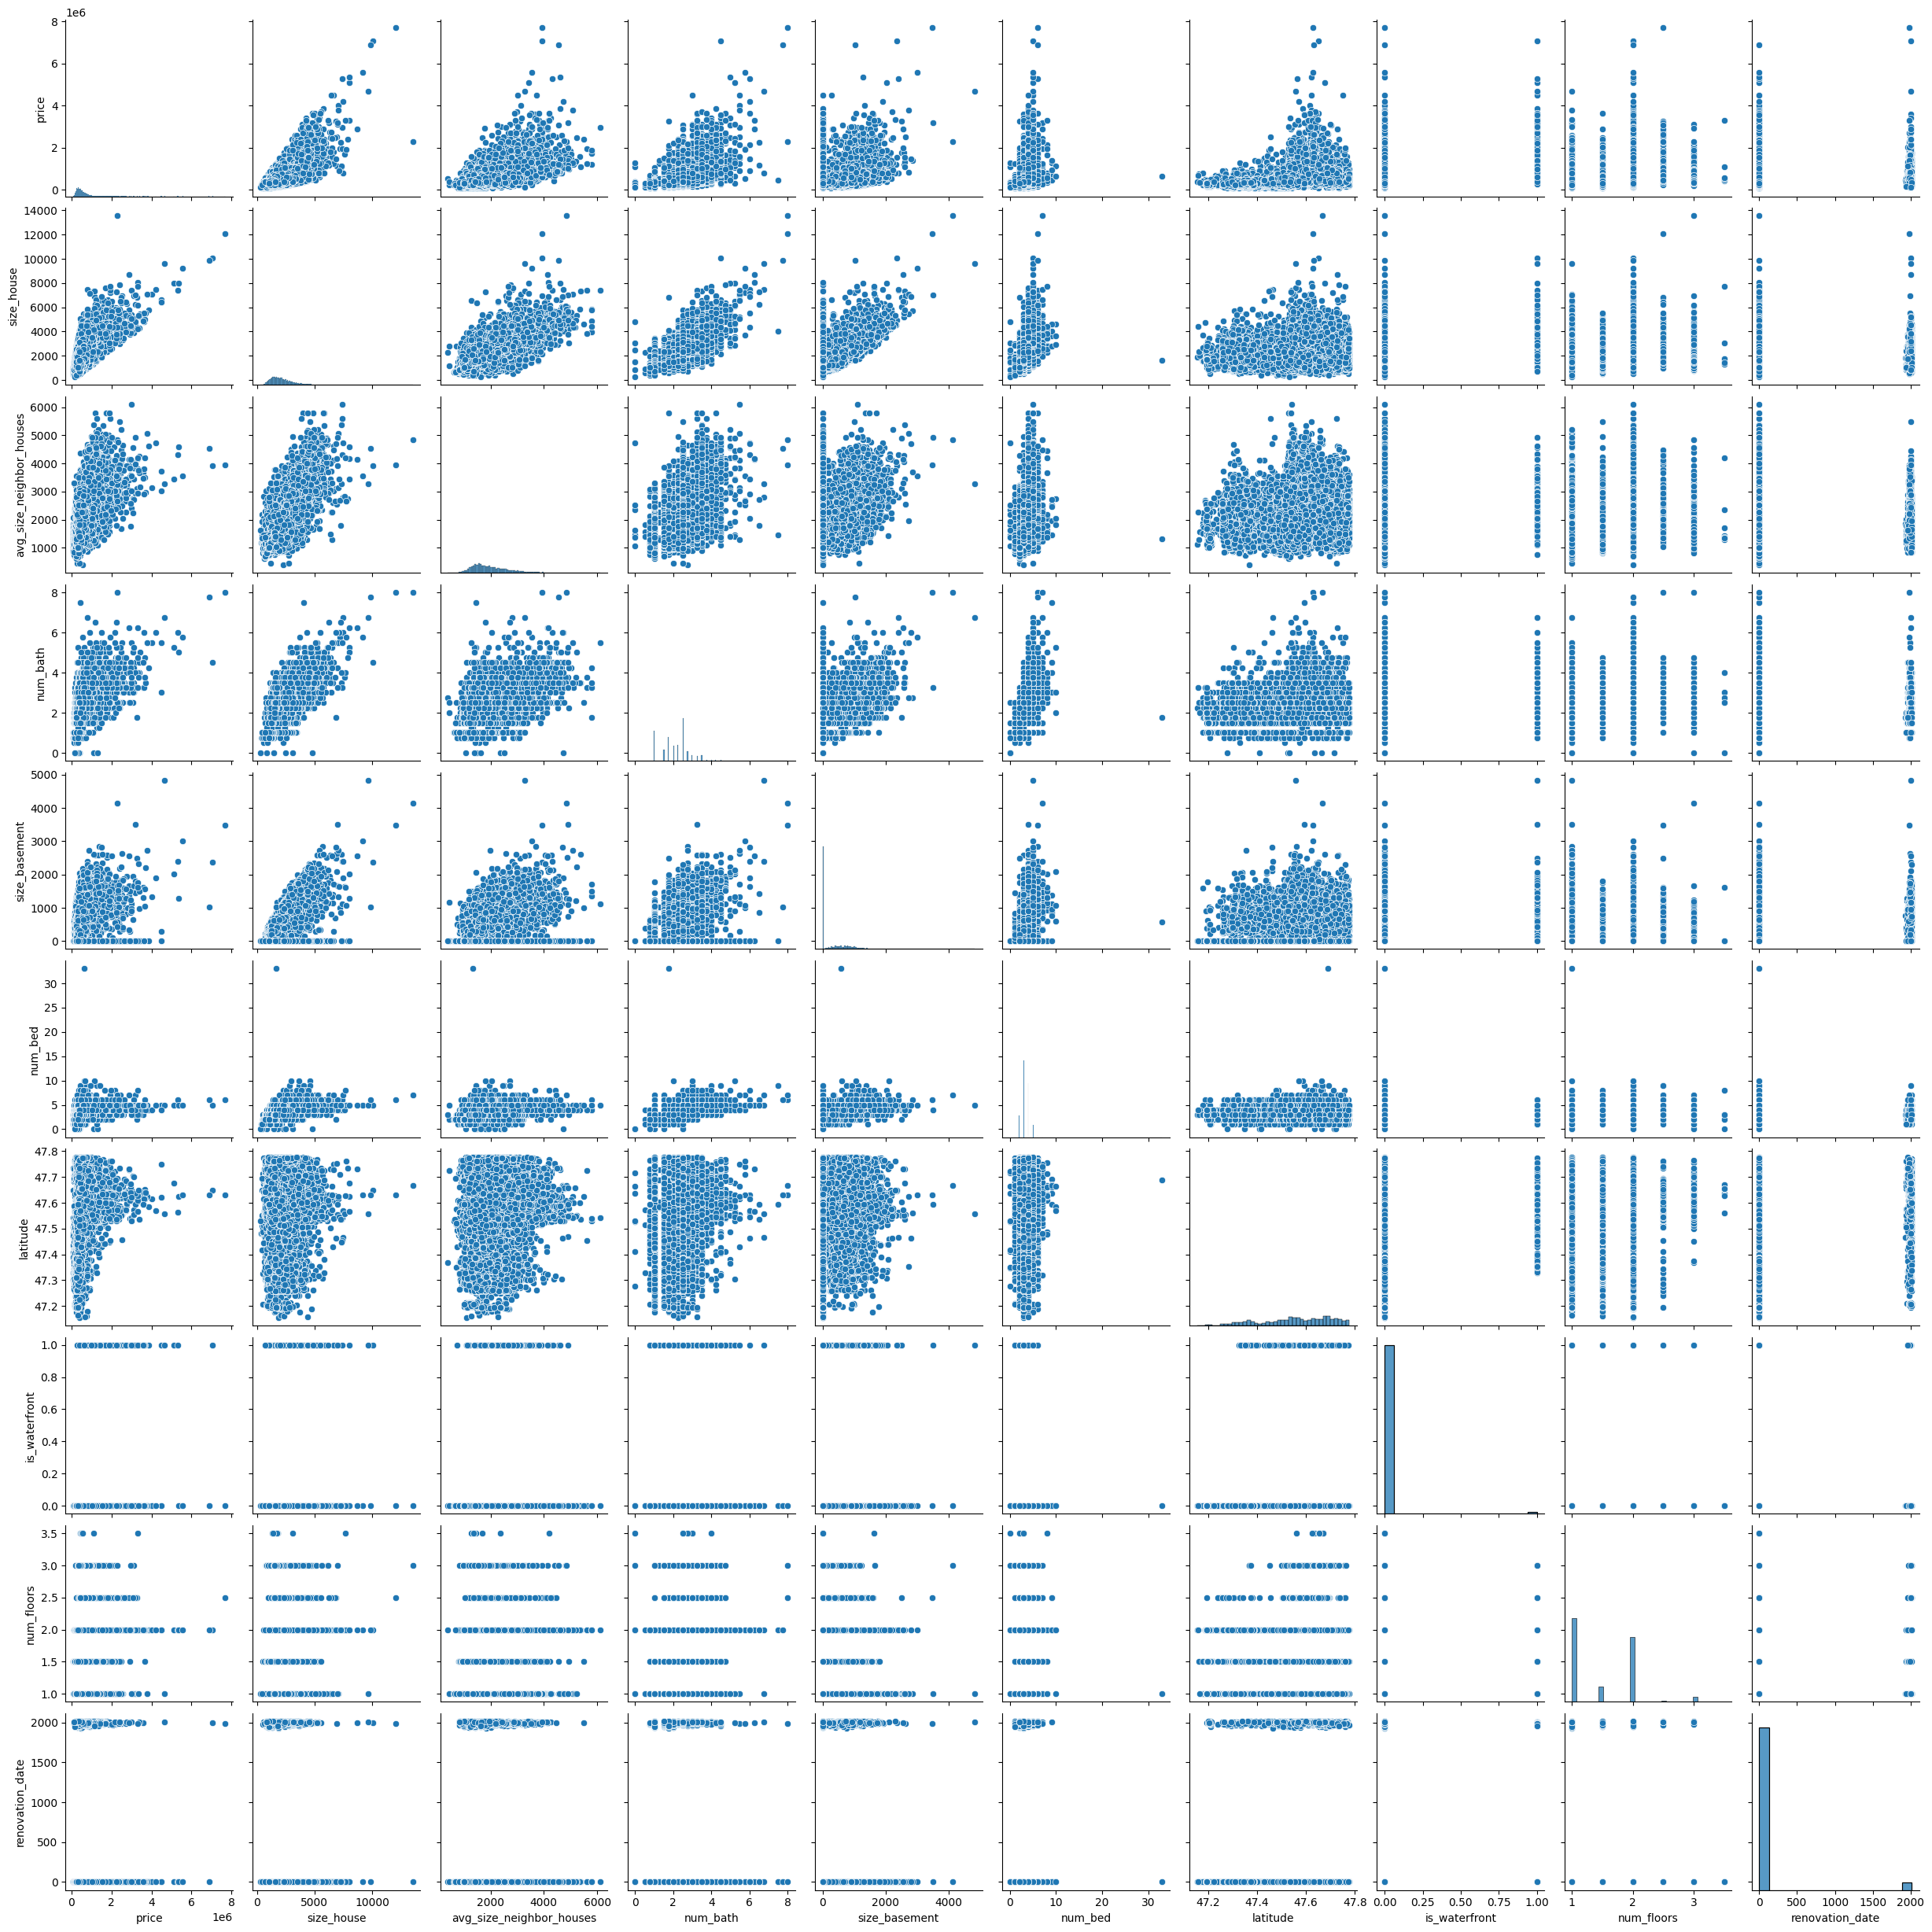

In [8]:
eda.pairplot()

# Outliers

As we plan on using a Regression model, at least for comparison, we need to take a closer look to outliers

**In size_house:**

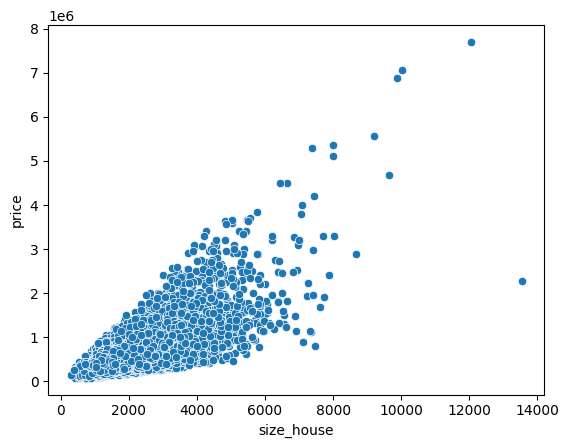

In [9]:
commons.scatterplot('size_house', 'price')

There's one point that seems to be an outlier so we decide to drop it

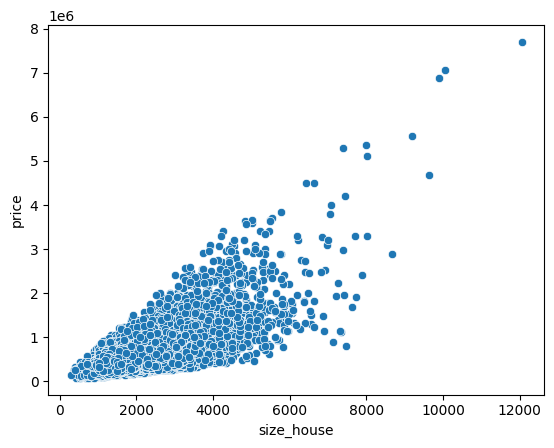

In [10]:
outliers.drop_outlier_gt_l(12000, 3e6, 'size_house', 'price')
commons.scatterplot('size_house', 'price')

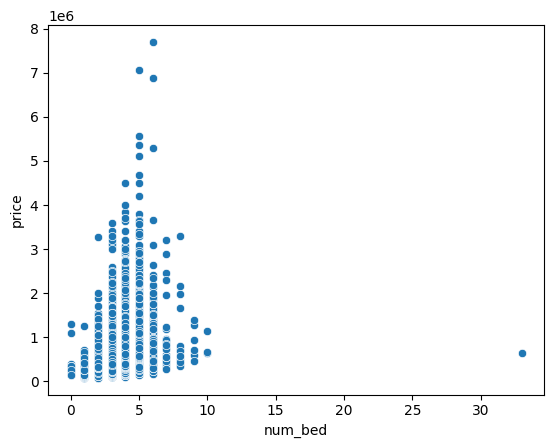

In [11]:
commons.scatterplot('num_bed', 'price')

We also drop this weird house with x>30 bedrooms that's really cheap

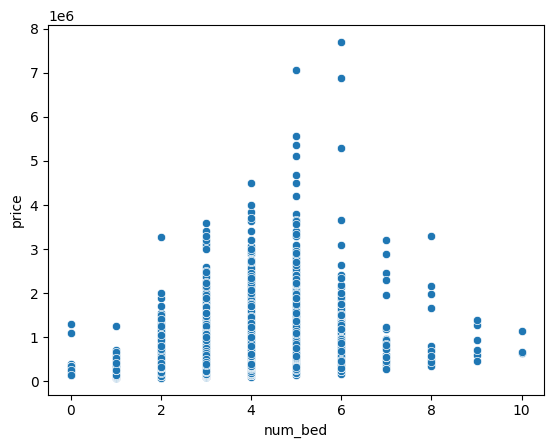

In [12]:
outliers.drop_outlier_gt_l(30, 3e6, 'num_bed', 'price')
commons.scatterplot('num_bed', 'price')

# Feature engineering

**Categorical Features**  


Features that are purely categorical (not ordinal):
- is_waterfront  
- zip

Ordinal Features:  
- num_bed
- num_bath
- num_floors 
- year_built
- condition
- renovation_date

**Adding Features**

- Total size  

    - May be useful to add a feature that keeps the total size of the house size_house + size_basement,   
we saw in the correlation matrix that space-related features have a strong correlation with price

In [13]:
feature_engineering.add_total_size()

- ZIP
    - The [zip code's](https://en.wikipedia.org/wiki/ZIP_Code#:~:text=ZIP%20Codes%20are%20numbered%20with,delivery%20addresses%20within%20that%20region.) first digit represents a group of US states
    - The second and third digit represent a region of that group
    - The fourth and fifth represent a a group of delivery addresses in that group

Our data set comes from a particular region of the US, let's see the distribution of the  
first digit of the zip code

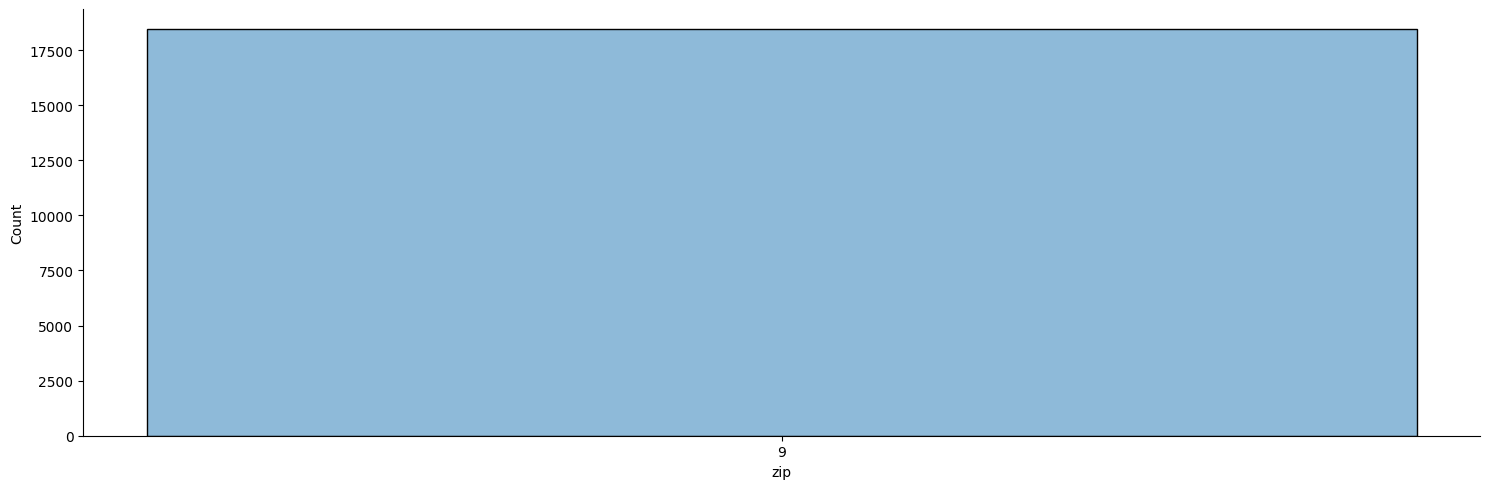

In [14]:
feature_engineering.view_zip([1])

Every zip code is from the same region of US, so the first digit of zipcode gives 0 information and we can drop it.  
Let's see the second and third digit: 

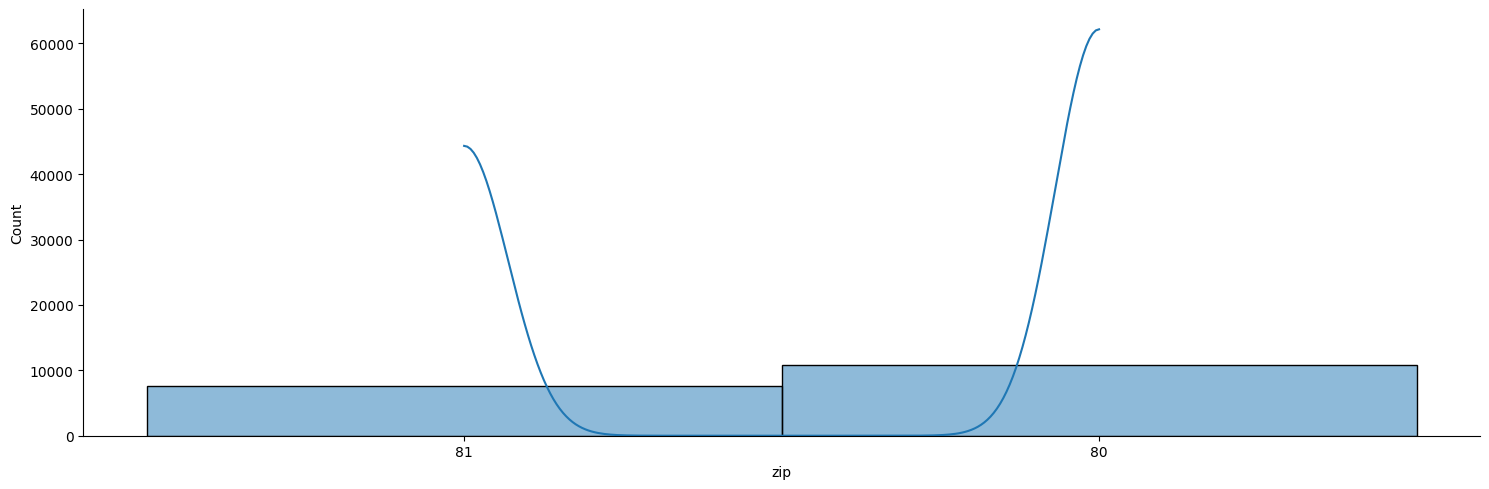

In [15]:
feature_engineering.view_zip([2,3])

So this digits do give some information.  

Let's see the distribution of the 4th and 5th digit for each group:

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/commons.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/commons.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)


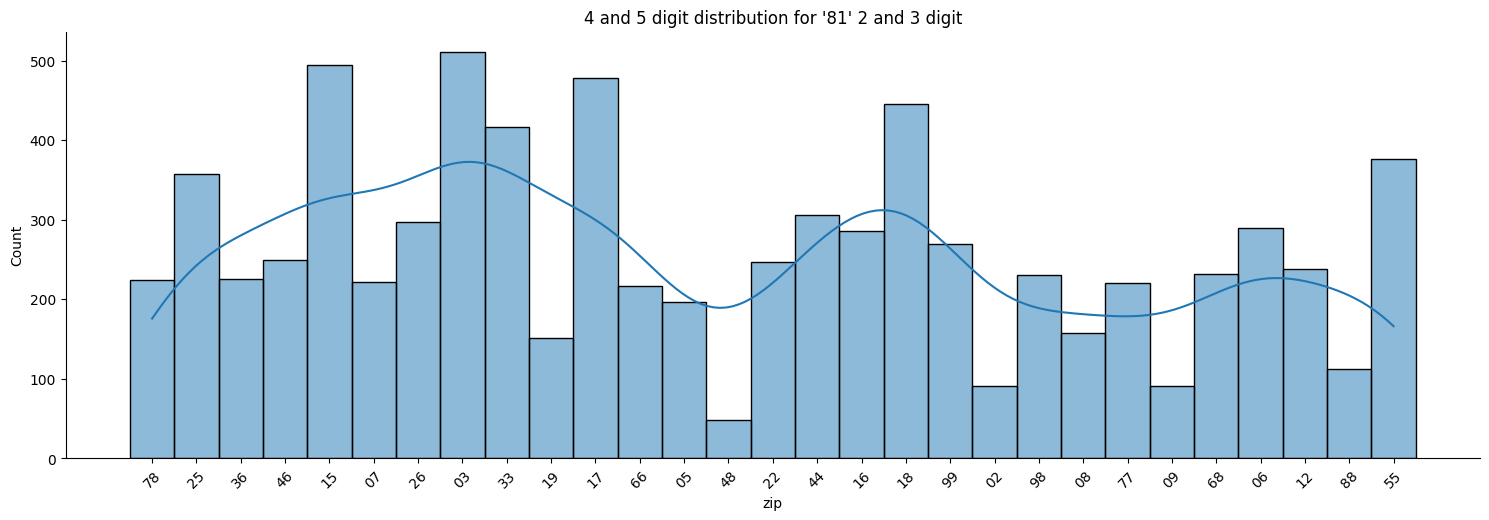

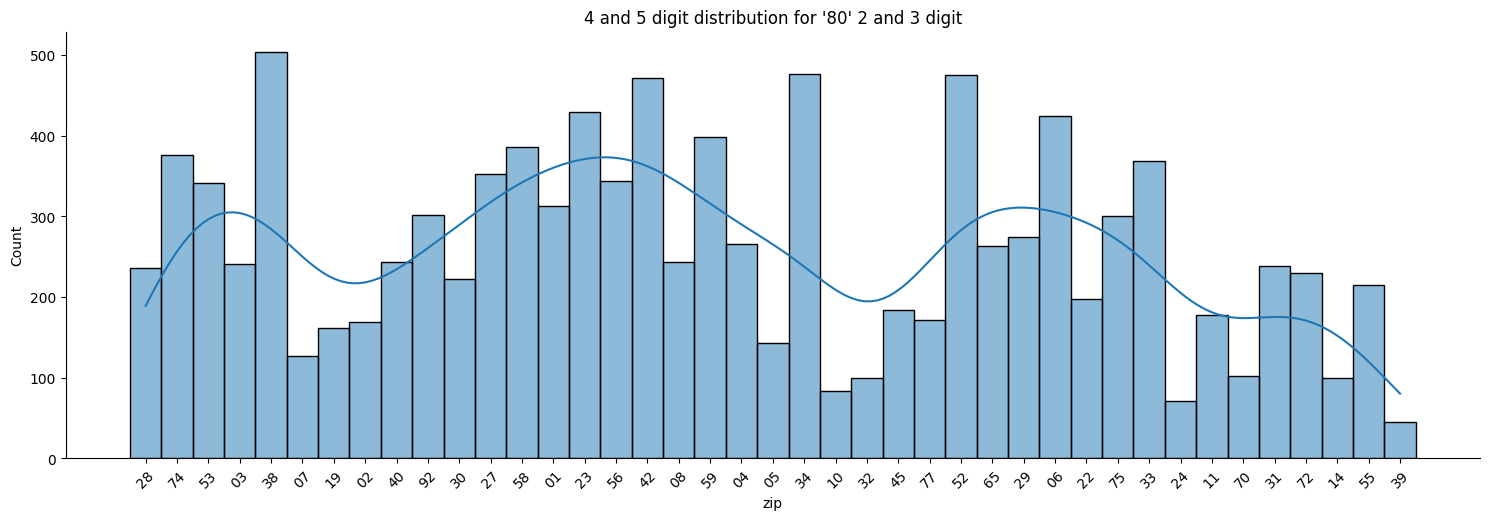

In [16]:
feature_engineering.view_zip([4,5],[2,3])

As such, we will:
- Create a 'group' column with the 2nd and third digit of zip
- Use the zip as a 4th and 5th zip digit indicator (removing the first digit is unnecesary as we will treat zip as a purely categorical feature, we keep the 2nd and 3rd digit to differentiate address '05' of group '80' from address '05' of group '81')

*From [here](https://en.wikipedia.org/wiki/ZIP_Code#:~:text=ZIP%20Codes%20are%20numbered%20with,delivery%20addresses%20within%20that%20region) is not clear that the order of the addresses represent closer or more separated locations, so we'll treat it as purely categorical*   
*Note that zip code only gives some spatial information that could be already contained in lat and long*

In [17]:
feature_engineering.create_group_feature()

price  num_bed  num_bath  size_house  size_lot  num_floors  \
0      221900        3      1.00        1180      5650         1.0   
1      538000        3      2.25        2570      7242         2.0   
2      180000        2      1.00         770     10000         1.0   
3      604000        4      3.00        1960      5000         1.0   
4      510000        3      2.00        1680      8080         1.0   
...       ...      ...       ...         ...       ...         ...   
18443  360000        3      2.50        1530      1131         3.0   
18444  400000        4      2.50        2310      5813         2.0   
18445  402101        2      0.75        1020      1350         2.0   
18446  400000        3      2.50        1600      2388         2.0   
18447  325000        2      0.75        1020      1076         2.0   

       is_waterfront  condition  size_basement  year_built  renovation_date  \
0                  0          3              0        1955                0   
1                  0          3            400        1951             1991   
2                  0          3              0        1933                0   
3                  0          5            910        1965                0   
4                  0          3              0        1987                0   
...              ...        ...            ...         ...              ...   
18443              0          3              0        2009                0   
18444              0          3              0        2014                0   
18445              0          3              0        2009                0   
18446              0          3              0        2004                0   
18447              0          3              0        2008                0   

         zip   latitude   longitude  avg_size_neighbor_houses  \
0      98178  47.511234 -122.256775                      1340   
1      98125  47.721023 -122.318862                      1690   
2      98028  47.737927 -122.233196                      2720   
3      98136  47.520820 -122.393185                      1360   
4      98074  47.616812 -122.044901                      1800   
...      ...        ...         ...                       ...   
18443  98103  47.699285 -122.346105                      1530   
18444  98146  47.510733 -122.361867                      1830   
18445  98144  47.594358 -122.298654                      1020   
18446  98027  47.534499 -122.069087                      1410   
18447  98144  47.594059 -122.298635                      1020   

       avg_size_neighbor_lot  total_size group  
0                       5650        1180    81  
1                       7639        2970    81  
2                       8062         770    80  
3                       5000        2870    81  
4                       7503        1680    80  
...                      ...         ...   ...  
18443                   1509        1530    81  
18444                   7200        2310    81  
18445                   2007        1020    81  
18446                   1287        1600    80  
18447                   1357        1020    81  

[18446 rows x 18 columns]

**Skewness**

As regression models assume multivariate normality and homoscedasticity  
and as we saw before, our target is highly skewed it is a good idea to transform the  
highly skewed features to approach normality.  
    We'll use Box-Cox transformation of 1+x (when lambda = 0 it's the log1p transformation )

*Note that even if we end up using a model not sensitive to skewed data (XGB), we still can  
use a regression model as performance comparison*

In [18]:
feature_engineering.get_skew()


Skew in features: 



Skew
size_lot                  13.432577
avg_size_neighbor_lot      9.080526
price                      4.118147
size_basement              1.546138
size_house                 1.418081
avg_size_neighbor_houses   1.098743
longitude                  0.850708
latitude                  -0.486401

**The target**  
Let's look again at the target distribution, and fit a normal distribution to it.

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


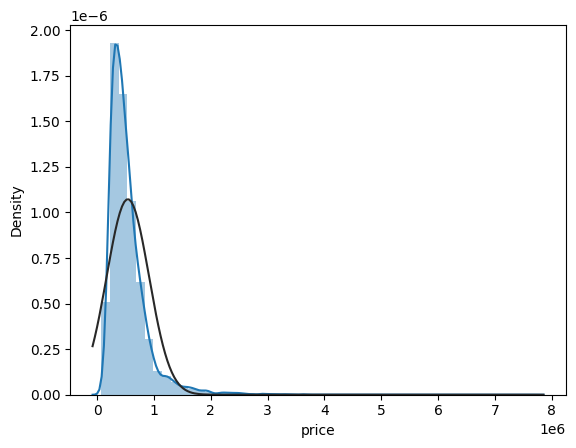

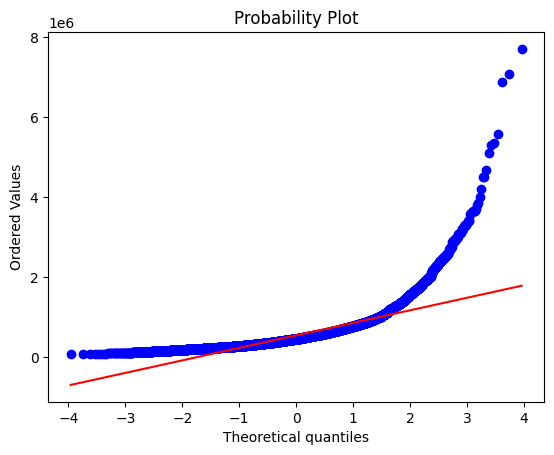

In [19]:
feature_engineering.fit_normal('price')

As we can see the target distribution is highly  positive skewed, and it doesn't follow the line in the PP plot.  
Hoping to fix both of these issues we'll log transform the target.

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


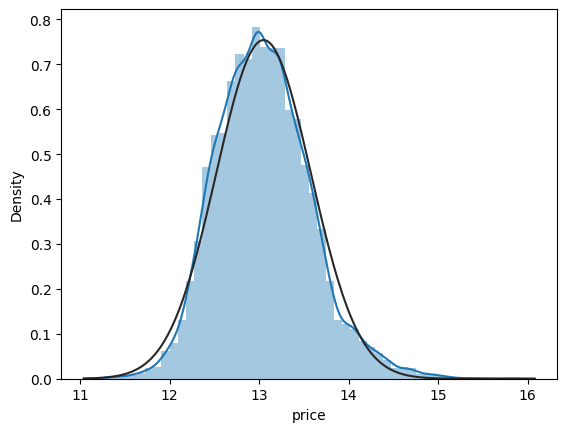

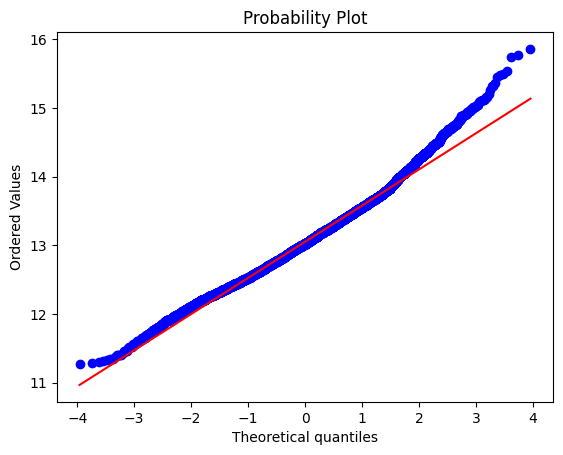

In [20]:
feature_engineering.boxcox('price',0)
feature_engineering.fit_normal('price')

Much better!

**Now for other skewed features**  
size_house:

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


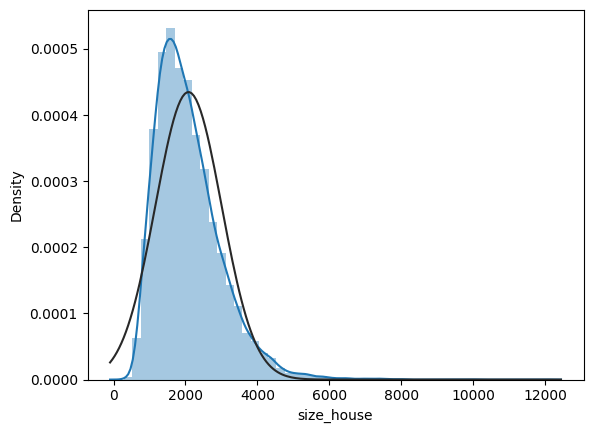

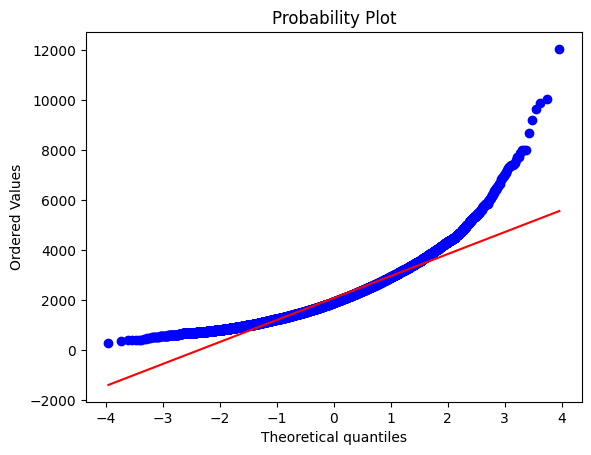

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


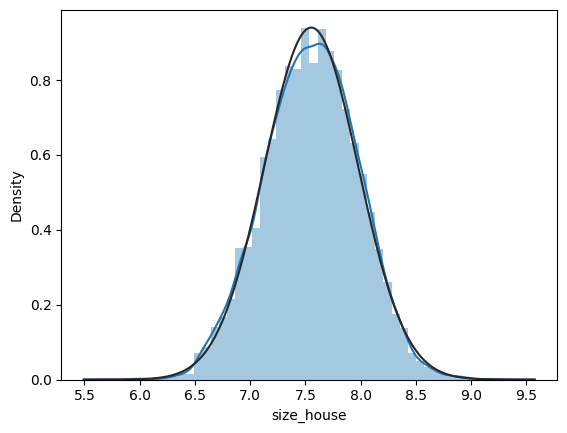

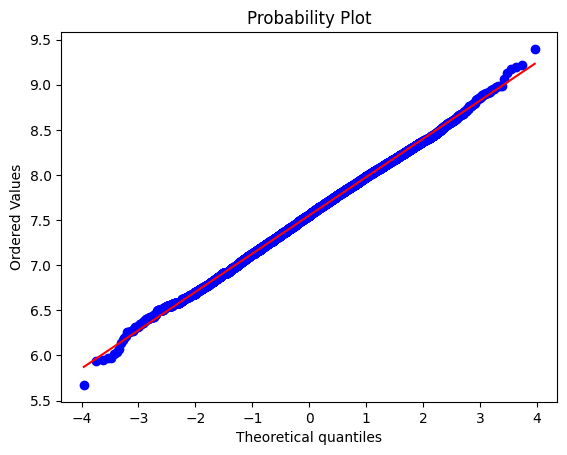

In [21]:
feature_engineering.fit_normal('size_house')
feature_engineering.boxcox('size_house',0)
feature_engineering.fit_normal('size_house')

avg_size_neighbor_houses:

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


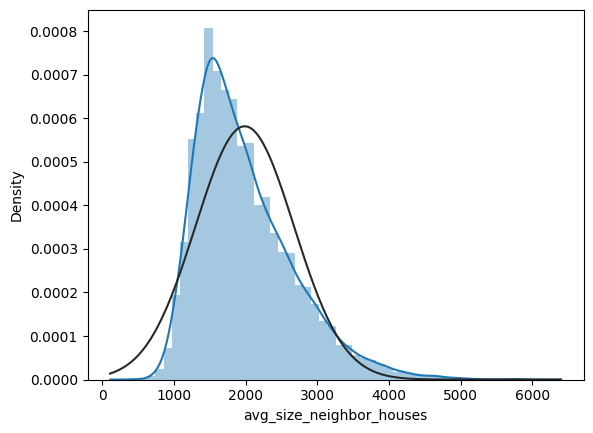

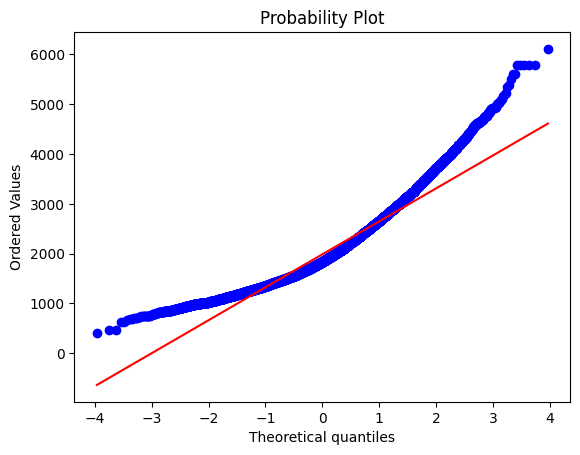

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/notebooks/../housing/feature_engineering.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DATA[feature], fit=norm)


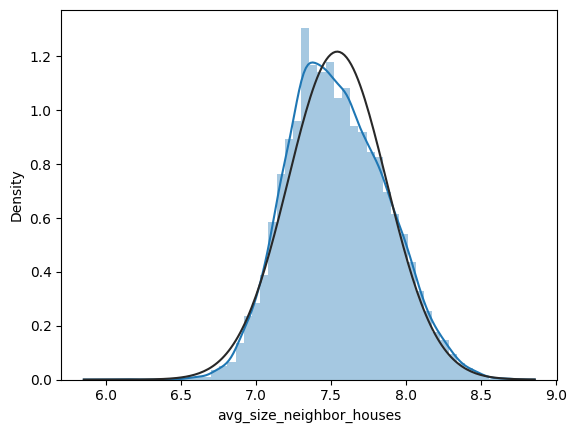

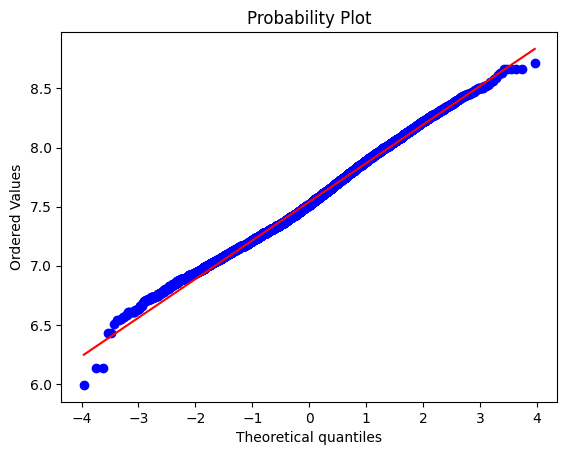

In [22]:
feature_engineering.fit_normal('avg_size_neighbor_houses')
feature_engineering.boxcox('avg_size_neighbor_houses',0)
feature_engineering.fit_normal('avg_size_neighbor_houses')

We transform the rest of the highly skewed features (>1)

In [23]:
feature_engineering.boxcox_mult(['size_lot', 'avg_size_neighbor_lot', 'size_basement'], 0)

**One Hot encoding**

Let's one hot encode the categorical data ('is_waterfront', 'group', 'zip')

feature_engineering.one_hot_encode(['is_waterfront','group','zip'])

**Ordinal encoding**  

Let's look at the type of ordinal columns again:

In [24]:
data_info.get_types(['num_bed',
'num_bath',
'num_floors',
'year_built',
'condition',
'renovation_date'])

Data types: 

num_bed              int64
num_bath           float64
num_floors         float64
year_built           int64
condition            int64
renovation_date      int64
dtype: object


- num_bed and condition:

In [25]:
commons.show_distinct('num_bed')
commons.show_distinct('condition')


Distinct values for num_bed
[ 3  2  4  5  1  6  7  0  8  9 10]
Distinct values for condition
[3 5 4 2 1]


These are already ordinally encoded, great!

- To preserve the numerical relations of the data (4 beds is 4 times as much that 1 bed) we'll get use a list \[min ,min+step,...max\] as the labels for each category

- num_floors:

In [26]:
commons.show_distinct('num_floors')

Distinct values for num_floors
[1.  2.  1.5 3.  2.5 3.5]


We'll use a step of 0.5 to ordinal encode this feature:

In [27]:
feature_engineering.ordinal_encode(['num_floors'],  0.5)

[array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])]
(18446, 18)
<class 'numpy.ndarray'>


ordinalencoder__num_floors      price num_bed num_bath size_house  \
0                            2.0  12.309987       3      1.0   7.074117   
1                            4.0  13.195616       3     2.25    7.85205   
2                            2.0  12.100718       2      1.0   6.647688   
3                            2.0  13.311331       4      3.0    7.58121   
4                            2.0  13.142168       3      2.0   7.427144   
...                          ...        ...     ...      ...        ...   
18441                        6.0  12.793862       3      2.5   7.333676   
18442                        4.0  12.899222       4      2.5   7.745436   
18443                        4.0  12.904461       2     0.75   6.928538   
18444                        4.0  12.899222       3      2.5   7.378384   
18445                        4.0  12.691584       2     0.75   6.928538   

       size_lot is_waterfront condition size_basement year_built  \
0      8.639588             0         3           0.0       1955   
1      8.887791             0         3      5.993961       1951   
2       9.21044             0         3           0.0       1933   
3      8.517393             0         5      6.814543       1965   
4      8.997271             0         3           0.0       1987   
...         ...           ...       ...           ...        ...   
18441  7.031741             0         3           0.0       2009   
18442  8.668024             0         3           0.0       2014   
18443    7.2086             0         3           0.0       2009   
18444   7.77863             0         3           0.0       2004   
18445  6.981935             0         3           0.0       2008   

      renovation_date    zip   latitude   longitude avg_size_neighbor_houses  \
0                   0  98178  47.511234 -122.256775                 7.201171   
1                1991  98125  47.721023 -122.318862                 7.433075   
2                   0  98028  47.737927 -122.233196                 7.908755   
3                   0  98136   47.52082 -122.393185                 7.215975   
4                   0  98074  47.616812 -122.044901                 7.496097   
...               ...    ...        ...         ...                      ...   
18441               0  98103  47.699285 -122.346105                 7.333676   
18442               0  98146  47.510733 -122.361867                 7.512618   
18443               0  98144  47.594358 -122.298654                 6.928538   
18444               0  98027  47.534499 -122.069087                 7.252054   
18445               0  98144  47.594059 -122.298635                 6.928538   

      avg_size_neighbor_lot total_size group  
0                  8.639588       1180    81  
1                  8.941153       2970    81  
2                  8.995041        770    80  
3                  8.517393       2870    81  
4                  8.923191       1680    80  
...                     ...        ...   ...  
18441              7.319865       1530    81  
18442              8.881975       2310    81  
18443              7.604894       1020    81  
18444              7.160846       1600    80  
18445              7.213768       1020    81  

[18446 rows x 18 columns]

- num_bath:

In [28]:
commons.show_distinct('num_bath')

Distinct values for num_bath
[1.0 2.25 3.0 2.0 4.5 2.5 1.75 2.75 1.5 3.25 3.5 0.75 4.0 4.75 5.0 4.25
 3.75 0.0 1.25 5.25 6.0 5.5 6.75 5.75 8.0 7.5 7.75 0.5 6.25 6.5]


From the feature descriptions we know that a fractional value means the house has a toilet-only or shower/bathtub-only bathroom.  
We'll use a 0.25 step for this feature.


In [29]:
feature_engineering.ordinal_encode(['num_bath'],  0.25)

[array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ,
       8.25, 8.5 , 8.75])]
(18446, 18)
<class 'numpy.ndarray'>


ordinalencoder__num_bath ordinalencoder__num_floors      price num_bed  \
0                          4.0                        2.0  12.309987       3   
1                          9.0                        4.0  13.195616       3   
2                          4.0                        2.0  12.100718       2   
3                         12.0                        2.0  13.311331       4   
4                          8.0                        2.0  13.142168       3   
...                        ...                        ...        ...     ...   
18441                     10.0                        6.0  12.793862       3   
18442                     10.0                        4.0  12.899222       4   
18443                      3.0                        4.0  12.904461       2   
18444                     10.0                        4.0  12.899222       3   
18445                      3.0                        4.0  12.691584       2   

      size_house  size_lot is_waterfront condition size_basement year_built  \
0       7.074117  8.639588             0         3           0.0       1955   
1        7.85205  8.887791             0         3      5.993961       1951   
2       6.647688   9.21044             0         3           0.0       1933   
3        7.58121  8.517393             0         5      6.814543       1965   
4       7.427144  8.997271             0         3           0.0       1987   
...          ...       ...           ...       ...           ...        ...   
18441   7.333676  7.031741             0         3           0.0       2009   
18442   7.745436  8.668024             0         3           0.0       2014   
18443   6.928538    7.2086             0         3           0.0       2009   
18444   7.378384   7.77863             0         3           0.0       2004   
18445   6.928538  6.981935             0         3           0.0       2008   

      renovation_date    zip   latitude   longitude avg_size_neighbor_houses  \
0                   0  98178  47.511234 -122.256775                 7.201171   
1                1991  98125  47.721023 -122.318862                 7.433075   
2                   0  98028  47.737927 -122.233196                 7.908755   
3                   0  98136   47.52082 -122.393185                 7.215975   
4                   0  98074  47.616812 -122.044901                 7.496097   
...               ...    ...        ...         ...                      ...   
18441               0  98103  47.699285 -122.346105                 7.333676   
18442               0  98146  47.510733 -122.361867                 7.512618   
18443               0  98144  47.594358 -122.298654                 6.928538   
18444               0  98027  47.534499 -122.069087                 7.252054   
18445               0  98144  47.594059 -122.298635                 6.928538   

      avg_size_neighbor_lot total_size group  
0                  8.639588       1180    81  
1                  8.941153       2970    81  
2                  8.995041        770    80  
3                  8.517393       2870    81  
4                  8.923191       1680    80  
...                     ...        ...   ...  
18441              7.319865       1530    81  
18442              8.881975       2310    81  
18443              7.604894       1020    81  
18444              7.160846       1600    80  
18445              7.213768       1020    81  

[18446 rows x 18 columns]

- Renovation date:

In [30]:
commons.show_distinct('renovation_date')

Distinct values for renovation_date
[0 1991 2002 2010 1999 1992 2013 1994 2005 2008 2003 1984 1954 2014 2011
 1974 1983 1945 1990 1988 1957 1977 1981 1995 1978 2000 1998 1970 1989
 1986 2009 2004 2007 1987 2006 1980 1971 1979 1997 1950 1969 1948 2015
 2001 1968 2012 1963 1951 1993 1962 1996 1972 1985 1955 1982 1940 1976
 1946 1975 1958 1964 1973 1965 1967 1934 1953 1960 1944]


We must first handle the 0 values, as these do NOT mean a renovation was made in year 0 but instead that a renovation hasn't ocurred.  
Therefore we will create a new binary feature (one hot encoded) to indicate if the house has been renovated.

In [31]:
feature_engineering.create_has_been_renovated()

ordinalencoder__num_bath ordinalencoder__num_floors      price num_bed  \
0                          4.0                        2.0  12.309987       3   
1                          9.0                        4.0  13.195616       3   
2                          4.0                        2.0  12.100718       2   
3                         12.0                        2.0  13.311331       4   
4                          8.0                        2.0  13.142168       3   
...                        ...                        ...        ...     ...   
18441                     10.0                        6.0  12.793862       3   
18442                     10.0                        4.0  12.899222       4   
18443                      3.0                        4.0  12.904461       2   
18444                     10.0                        4.0  12.899222       3   
18445                      3.0                        4.0  12.691584       2   

      size_house  size_lot is_waterfront condition size_basement year_built  \
0       7.074117  8.639588             0         3           0.0       1955   
1        7.85205  8.887791             0         3      5.993961       1951   
2       6.647688   9.21044             0         3           0.0       1933   
3        7.58121  8.517393             0         5      6.814543       1965   
4       7.427144  8.997271             0         3           0.0       1987   
...          ...       ...           ...       ...           ...        ...   
18441   7.333676  7.031741             0         3           0.0       2009   
18442   7.745436  8.668024             0         3           0.0       2014   
18443   6.928538    7.2086             0         3           0.0       2009   
18444   7.378384   7.77863             0         3           0.0       2004   
18445   6.928538  6.981935             0         3           0.0       2008   

      renovation_date    zip   latitude   longitude avg_size_neighbor_houses  \
0                   0  98178  47.511234 -122.256775                 7.201171   
1                1991  98125  47.721023 -122.318862                 7.433075   
2                   0  98028  47.737927 -122.233196                 7.908755   
3                   0  98136   47.52082 -122.393185                 7.215975   
4                   0  98074  47.616812 -122.044901                 7.496097   
...               ...    ...        ...         ...                      ...   
18441               0  98103  47.699285 -122.346105                 7.333676   
18442               0  98146  47.510733 -122.361867                 7.512618   
18443               0  98144  47.594358 -122.298654                 6.928538   
18444               0  98027  47.534499 -122.069087                 7.252054   
18445               0  98144  47.594059 -122.298635                 6.928538   

      avg_size_neighbor_lot total_size group  has_been_renovated  
0                  8.639588       1180    81                   1  
1                  8.941153       2970    81                   0  
2                  8.995041        770    80                   1  
3                  8.517393       2870    81                   1  
4                  8.923191       1680    80                   1  
...                     ...        ...   ...                 ...  
18441              7.319865       1530    81                   1  
18442              8.881975       2310    81                   1  
18443              7.604894       1020    81                   1  
18444              7.160846       1600    80                   1  
18445              7.213768       1020    81                   1  

[18446 rows x 19 columns]

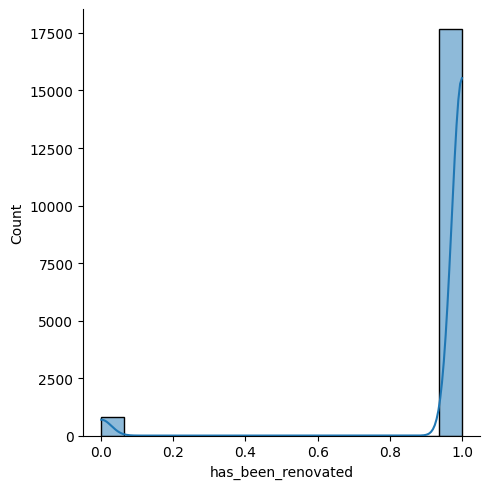

In [32]:
commons.plot_feature_distribution('has_been_renovated')

In [33]:
feature_engineering.one_hot_encode(['has_been_renovated'])

(18446, 20)
<class 'numpy.ndarray'>


onehotencoder__has_been_renovated_0 onehotencoder__has_been_renovated_1  \
0                                     0.0                                 1.0   
1                                     1.0                                 0.0   
2                                     0.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   
...                                   ...                                 ...   
18441                                 0.0                                 1.0   
18442                                 0.0                                 1.0   
18443                                 0.0                                 1.0   
18444                                 0.0                                 1.0   
18445                                 0.0                                 1.0   

      ordinalencoder__num_bath ordinalencoder__num_floors      price num_bed  \
0                          4.0                        2.0  12.309987       3   
1                          9.0                        4.0  13.195616       3   
2                          4.0                        2.0  12.100718       2   
3                         12.0                        2.0  13.311331       4   
4                          8.0                        2.0  13.142168       3   
...                        ...                        ...        ...     ...   
18441                     10.0                        6.0  12.793862       3   
18442                     10.0                        4.0  12.899222       4   
18443                      3.0                        4.0  12.904461       2   
18444                     10.0                        4.0  12.899222       3   
18445                      3.0                        4.0  12.691584       2   

      size_house  size_lot is_waterfront condition size_basement year_built  \
0       7.074117  8.639588             0         3           0.0       1955   
1        7.85205  8.887791             0         3      5.993961       1951   
2       6.647688   9.21044             0         3           0.0       1933   
3        7.58121  8.517393             0         5      6.814543       1965   
4       7.427144  8.997271             0         3           0.0       1987   
...          ...       ...           ...       ...           ...        ...   
18441   7.333676  7.031741             0         3           0.0       2009   
18442   7.745436  8.668024             0         3           0.0       2014   
18443   6.928538    7.2086             0         3           0.0       2009   
18444   7.378384   7.77863             0         3           0.0       2004   
18445   6.928538  6.981935             0         3           0.0       2008   

      renovation_date    zip   latitude   longitude avg_size_neighbor_houses  \
0                   0  98178  47.511234 -122.256775                 7.201171   
1                1991  98125  47.721023 -122.318862                 7.433075   
2                   0  98028  47.737927 -122.233196                 7.908755   
3                   0  98136   47.52082 -122.393185                 7.215975   
4                   0  98074  47.616812 -122.044901                 7.496097   
...               ...    ...        ...         ...                      ...   
18441               0  98103  47.699285 -122.346105                 7.333676   
18442               0  98146  47.510733 -122.361867                 7.512618   
18443               0  98144  47.594358 -122.298654                 6.928538   
18444               0  98027  47.534499 -122.069087                 7.252054   
18445               0  98144  47.594059 -122.298635                 6.928538   

      avg_size_neighbor_lot total_size group  
0                  8.639588       1180    81  
1                  8.941153       2970    81  
2                  8.

The rest of renovation years are already ordinally encoded.  
We must re-escale this feature as leaving it as is will distort the results because of the fictional distance between year 0 and the year of the renovations, once reescaled we hope to capture the 0 behaviour with the has_been_renovated feature

- year_built is already ordinally encoded, and it doesn't have 0 values

In [34]:
commons.show_distinct('year_built')
print(commons.get_limits('year_built'))

Distinct values for year_built
[1955 1951 1933 1965 1987 2001 1995 1960 2003 1942 1927 1900 1979 1994
 1916 1921 1969 1947 1968 1985 1941 1915 1948 2005 1929 1981 1930 1904
 2000 1984 2014 1922 1959 1966 1953 1950 2008 1991 1954 1973 1925 1972
 1956 2002 1992 1964 1952 1961 2006 1988 1962 1939 1946 1967 1975 1980
 1910 1983 1978 1905 1971 2010 1945 1924 1990 1914 1926 2004 1986 1923
 2007 1996 1976 1949 1999 1901 1993 1977 1920 1997 1943 1957 1940 1918
 1928 1974 1911 1936 1937 1982 1989 1908 1931 1963 1998 1913 2013 1907
 1958 1909 1912 2011 1917 1932 1944 1902 2009 1903 1970 2012 1934 1938
 1919 1906 2015 1935]
[1900, 2015]


In [35]:
data=data_holder.get_data()
data.describe()

onehotencoder__has_been_renovated_0  \
count                               18446.0   
unique                                  2.0   
top                                     0.0   
freq                                17659.0   

        onehotencoder__has_been_renovated_1  ordinalencoder__num_bath  \
count                               18446.0                   18446.0   
unique                                  2.0                      30.0   
top                                     1.0                      10.0   
freq                                17659.0                    4607.0   

        ordinalencoder__num_floors         price  num_bed    size_house  \
count                      18446.0  18446.000000    18446  18446.000000   
unique                         6.0   3669.000000       11    955.000000   
top                            2.0     12.765691        3      7.273093   
freq                        9123.0    145.000000     8403    125.000000   

            size_lot  is_waterfront  condition  size_basement  year_built  \
count   18446.000000          18446      18446        18446.0       18446   
unique   8806.000000              2          5          282.0         116   
top         8.517393              0          3            0.0        2014   
freq      309.000000          18305      11940        11174.0         468   

        renovation_date    zip     latitude     longitude  \
count             18446  18446  18446.00000  18446.000000   
unique               68     70  18322.00000  18285.000000   
top                   0  98103     47.50449   -122.330116   
freq              17659    511      3.00000      3.000000   

        avg_size_neighbor_houses  avg_size_neighbor_lot  total_size  group  
count               18446.000000           18446.000000       18446  18446  
unique                734.000000            7865.000000        1076      2  
top                     7.353082               8.517393        1300     80  
freq                  171.000000             375.000000         106  10767

# Standardize


Lets use a Elastic Net regression model as our baseline.

In [36]:
en=ElasticNet()
param_grid = {
    "alpha": [1e-5, 1e-4, 1e-3],
    "l1_ratio": np.arange(0, 0.05, 0.01),
}
CV_en = GridSearchCV(estimator=en, param_grid=param_grid, cv= 5, scoring='neg_root_mean_squared_error')
data=data_holder.get_data()
X = data.drop('price', axis=1)
results=CV_en.fit(X,data['price'])
print([results.best_score_, results.best_params_])

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.450e+02, tolerance: 4.085e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.389e+02, tolerance: 4.123e-01 Linear regression models with null weight for the l1 regularization 

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.415e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.445e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.353e+02, tolerance: 4.072e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.27272054066593954, {'alpha': 1e-05, 'l1_ratio': 0.01}]


/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.792e+02, tolerance: 5.161e-01
  model = cd_fast.enet_coordinate_descent(


Let's see if standardizing the non one-hot encoded columns we get better results:

In [37]:
non_ohe_columns = models.get_non_ohe_columns()
transformer = models.make_standard_scaler_transformer(non_ohe_columns)
sEn = models.make_pipeline(transformer, ElasticNet(alpha=results.best_params_['alpha'], l1_ratio=results.best_params_['l1_ratio']))
print(models.cross_validation_error(sEn))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.439e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e+02, tolerance: 4.123e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.2727019543804867, 0.004298244404905737]


/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.408e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(


What happens if we standardize the one hot encoded columns?

In [38]:
transformer2 = models.make_standard_scaler_transformer()
sEn = models.make_pipeline(transformer2, ElasticNet(alpha=results.best_params_['alpha'], l1_ratio=results.best_params_['l1_ratio']))
print(models.cross_validation_error(sEn))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.440e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.379e+02, tolerance: 4.123e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.2727208032983599, 0.004298284807232778]


/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.409e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(


Surprisingly we obtain the same score, so we can transform every column to make the pipeline more simple

# Models

As we need to predict a continuos value we'll use regression models, we'll test XGBoost, Elastic Net Regression, Kernel Ridge Regression, Lasso Regresion and SGD Regressor. Then take the equally well performing models and build a Voting Regressor.  
We'll use 5-fold cross validation to compute scores and avoid overfitting, scoring with negative root mean squared error to get the error in the same units as our target

**XGBoost**

In [39]:
xgb_m=models.create_xgb()
xgb_m_pipeline=models.make_pipeline(StandardScaler(), xgb_m)
print(models.cross_validation_error(xgb_m_pipeline))

[-0.1708261384947813, 0.0032891803146496775]


**Elastic Net Regression**

In [40]:
en=models.create_elastic_net()
en_pipeline=models.make_pipeline(StandardScaler(), en)
print(models.cross_validation_error(en_pipeline))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.253e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.189e+02, tolerance: 4.123e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.2727411348962856, 0.004287437647254777]


/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.233e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(


**Kernel Ridge regression**

In [41]:
r=models.create_kernel_ridge()
r_pipeline=models.make_pipeline(StandardScaler(), r)
print(models.cross_validation_error(r_pipeline))

[-0.22972784056705614, 0.003123395593363856]


**Lasso**

In [42]:
l=models.create_lasso()
l_pipeline=models.make_pipeline(StandardScaler(), l)
print(models.cross_validation_error(l_pipeline))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+02, tolerance: 4.123e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.272753431365621, 0.004290816094816352]


/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+02, tolerance: 4.188e-01
  model = cd_fast.enet_coordinate_descent(


**SGD**

In [43]:
sgd=models.create_sdg()
sgd_pipeline=models.make_pipeline(StandardScaler(), sgd)
print(models.cross_validation_error(sgd_pipeline))

[-0.27293618622913113, 0.004423865360705894]


**Voting Regressor**  

we'll give xgb more weight as is the one that performs better

In [44]:
vr=models.VotingRegressor([('xgb',xgb_m),('en',en),('r',r),('l',l),('sgd', sgd)],weights=[0.6,0.1,0.1,0.1,0.1])
vr_pipeline=models.make_pipeline(StandardScaler(), vr)
print(models.cross_validation_error(vr_pipeline))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.253e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+02, tolerance: 4.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-0.18585856372954176, 0.0029917329675906434]


Great!! the voting regressor performs better

# Building the final pipeline

**Adding total size feature**

In [45]:
total_size_transformer = final_pipeline.build_total_size_transformer()
data=pd.read_csv('../data/house_sales.csv')
total_size_transformer.fit_transform(data).shape

(18448, 1)

**Adding group feature, extracting 2nd and 3rd digit from zip:**

In [46]:
group_feat_transformer = final_pipeline.build_group_feat_transformer()
data=pd.read_csv('../data/house_sales.csv')
group_feat_transformer.fit_transform(data).shape

(18448, 1)

**Box-Cox transform size_house avg_size_neighbor_houses size_lot avg_size_neighbor_lot size_basement**

In [47]:
boxcox_transformer = final_pipeline.build_box_cox_transformer()
data=pd.read_csv('../data/house_sales.csv')
boxcox_transformer.fit_transform(data).shape

(18448, 5)

**Create has been renovated feature**

In [48]:
has_been_renovated_transformer = final_pipeline.build_has_been_renovated_transformer()
data=pd.read_csv('../data/house_sales.csv')
has_been_renovated_transformer.fit_transform(data).shape

(18448, 1)

**One hot encoding 'is_waterfront','zip'**

In [49]:
onehot_transformer=final_pipeline.build_one_hot_transformer()
data=pd.read_csv('../data/house_sales.csv')
onehot_transformer.fit_transform(data).shape

(18448, 72)

**One hot encode 'has_been_renovated'and 'group'**

Done inside final_pipeline.build_final_pipeline

**Final pipeline**

In [52]:
fp = final_pipeline.build_final_pipeline(total_size_transformer, group_feat_transformer, boxcox_transformer, has_been_renovated_transformer,onehot_transformer,vr)
data=pd.read_csv('../data/house_sales.csv')
X = data.drop('price', axis=1)
print(cross_val_score(fp,X,data['price'],scoring='neg_root_mean_squared_error'))

/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.643e+02, tolerance: 4.088e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+01, tolerance: 4.088e-01
  model = cd_fast.enet_coordinate_descent(
/Users/joseAraya/Documents/GitHub/rappi-ds-housing/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

[-130242.73837355 -143277.5934266  -123946.45136683 -128759.17443496
 -135072.31707301]
